In [1]:
import sys
sys.executable

'C:\\Users\\Monoid\\anaconda3\\envs\\nn\\python.exe'

파이썬 환경 확인.
envs\\nn\\python.exe 으로 끝나기를 기대합니다

In [2]:
from time import sleep
from tqdm import tqdm, trange

lst = [i for i in range(5)]

for element in tqdm(lst):
    sleep(0.1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


### tqdm 소개
tqdm은 다음과 같이 Progress bar 그려주는 라이브러리이에요. 와! 편하다.
```
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
```
이건 0에서 멈춰이있고 작동하지 않더라고요. 왜인진 몰라요.

In [3]:
from preprocessing import readPreporcssedDataAll
import torch
from torch.utils.data import Dataset, DataLoader
from dataset import make_collate_fn, DatasetArray
from transformers import BertTokenizer
import torch.nn as nn
from read_data import TagIdConverter

대충 필요한 것 임포트

In [4]:
tagIdConverter = TagIdConverter()

In [5]:
print("cuda available :",torch.cuda.is_available())
print("available device count :",torch.cuda.device_count())

if torch.cuda.is_available():
    device_index = torch.cuda.current_device()
    print("device name:",torch.cuda.get_device_name(device_index))

cuda available : True
available device count : 1
device name: NVIDIA GeForce RTX 3070


cuda가 가능한지 먼저 확인해보아요.

In [6]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

my_collate_fn = make_collate_fn(tokenizer)

데이터 로딩 준비

In [7]:
from transformers import BertModel

In [8]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
class MyModel(nn.Module):
    def __init__(self,output_feat: int,bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.1)
        self.lin = nn.Linear(768,output_feat) #[batch_size,word_size,768] -> [batch_size,word_size,output_feat]
        self.softmax = nn.Softmax(2) #[batch_size,word_size,output_feat] -> [batch_size,word_size,output_feat]
        #0부터 시작해서 2 번째 차원에 softmax.

    def forward(self,**kargs):
        emb = self.bert(**kargs)
        e = self.dropout(emb['last_hidden_state'])
        w = self.lin(e)
        return w

모델 선언
`nn.CrossEntropy`는 소프트맥스를 겸함.

In [10]:
model = MyModel(22,bert)
model.cuda()
bert.cuda()
print(model)

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

Tag의 종류가 22가지 입니다. 그래서 22을 넣었어요.

생성과 동시에 gpu로 옮기자.
`cuda` 저거 호출하면 됨.

In [11]:
print("bert current device :",bert.device)

bert current device : cuda:0


In [12]:
#for param in bert.parameters():
#    param.requires_grad = False

bert 는 업데이트 하지 않는다. 메모리를 아낄 수 있다.

In [13]:
device = torch.device("cuda")
device

device(type='cuda')

In [28]:
inputs = {'input_ids': torch.tensor([[  101, 39671,  8935, 73380, 30842,  9632,   125,  9998,  9251,  9559,
          9294,  8932, 28143,  9952,  8872,   127,  9489, 34907,  9952,  9279,
         12424,   102]],device=device), 
          'token_type_ids': torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],device=device), 
          'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],device=device)}

적당한 인풋을 정의한다

In [29]:
emb = model(**inputs)

In [30]:
emb.size()

torch.Size([1, 22, 22])

결과가 잘 나왔어요.

In [31]:
entity_ids = torch.tensor([21,21,7,17,17,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21]
                          ,dtype=torch.int64,device=device)

잘 이해하지는 못하겠는데, int64면 실행이 되고 int32이면 실행이 안된다.
```
RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'
```
이런 오류를 내면서 죽음.

In [32]:
emb.view(-1,emb.size(-1)).size()

torch.Size([22, 22])

In [36]:
predict = emb.view(-1,emb.size(-1)).argmax(dim=-1)
predict

tensor([19, 13, 21, 21, 19, 21, 13, 13, 16, 16, 21, 16, 19, 13,  2, 13, 13, 16,
        13, 20, 19, 19], device='cuda:0')

In [39]:
(predict == entity_ids)

tensor([False, False, False, False, False,  True, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False], device='cuda:0')

In [38]:
(predict == entity_ids) * inputs["attention_mask"]

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')

In [19]:
nn.CrossEntropyLoss(ignore_index=tagIdConverter.pad_id)(emb.view(-1,emb.size(-1)),entity_ids)

tensor(2.9564, device='cuda:0', grad_fn=<NllLossBackward0>)

크로스 엔트로피를 계산하는 데에 성공.
ignore_index는 padding class를 넣어요.

In [40]:
del inputs
del entity_ids
del emb

본격적으로 학습시켜봅시다.

In [21]:
datasetTrain, datasetDev, datasetTest = readPreporcssedDataAll()

데이터 셋이 적어도 어느정도 성능이 나와하야 할지 생각해봅시다.
`O` 토큰으로 범벅이 되있으니 전부 `O`로 찍는 것 보다 좋은 성능이 나와야 하지 않겠어요?
한번 시도해봅시다.

In [22]:
total_l = 0
total_o = 0

for item in tqdm(datasetTrain):
    entities = item["entity"]
    l = len(entities)
    o = sum(map(lambda x: 1 if x == "O" else 0,entities))
    total_l += l
    total_o += o

print(f"{total_o}/{total_l} = {total_o/total_l}")

100%|██████████████████████████████████████████████████████████████████████████| 4250/4250 [00:00<00:00, 236146.99it/s]

151572/190488 = 0.7957036663726849


79% 보다 높아야 해요.

In [23]:
BATCH_SIZE = 4
train_loader = DataLoader(
        DatasetArray(datasetTrain),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=my_collate_fn
)
dev_loader = DataLoader(
        DatasetArray(datasetDev),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=my_collate_fn
)
test_loader = DataLoader(
        DatasetArray(datasetTest),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=my_collate_fn
)

BATCH_SIZE 를 4로 잡는다.
bert paramter를 freeze 안했을땐 batch를 8 정도로 했어요. 그 이상은 메모리가 부족해서 돌아가지 않아요.


In [24]:
my_collate_fn(datasetTrain[0:1])

({'input_ids': tensor([[  101, 39671,  8935, 73380, 30842,  9632,   125,  9998,  9251,  9559,
            9294,  8932, 28143,  9952,  8872,   127,  9489, 34907,  9952,  9279,
           12424,   102]]),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
  'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])},
 tensor([[21, 21,  7, 17, 17, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
          21, 21, 21, 21]]))

데이터를 한번 더 확인

In [25]:
from torch.optim import AdamW

tqdm 확인

In [26]:
optimizer = AdamW(model.parameters(), lr=1.0e-5)
CELoss = nn.CrossEntropyLoss(ignore_index=tagIdConverter.pad_id)

옵티마이져 준비

In [27]:
from groupby_index import groupby_index

for g in groupby_index([1,2,3,4,5,6,7,8],4):
        print([*g])

[1, 2, 3, 4]
[5, 6, 7, 8]


`groupby_index` 그룹으로 묶어서 실행

In [43]:
TRAIN_EPOCH = 5

result = []
iteration = 0

t = []

model.zero_grad()

for epoch in range(TRAIN_EPOCH):
    model.train()
    print(f"epoch {epoch} start:")
    with tqdm(train_loader, unit="minibatch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        
        for batch in groupby_index(tepoch,8):
            corrects = 0
            totals = 0
            losses = 0
            
            optimizer.zero_grad()
            for mini_i,mini_l in batch:
                batch_inputs = {k: v.cuda(device) for k, v in list(mini_i.items())}
                batch_labels = mini_l.cuda(device)
                attention_mask = batch_inputs["attention_mask"]
                
                output = model(**batch_inputs)
                loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))
            
                prediction = output.view(-1, output.size(-1)).argmax(dim=-1)
                corrects += ((prediction == batch_labels.view(-1)) * attention_mask.view(-1)).sum().item()
                totals += attention_mask.view(-1).sum().item()
                losses += loss.item()
                loss.backward()

            optimizer.step()
            accuracy = corrects / totals
            result.append({"iter":iteration,"loss":losses,"accuracy":accuracy})
            tepoch.set_postfix(loss=losses, accuracy= accuracy)
            iteration += 1

epoch 0 start:


Epoch 0: 100%|███████████████████████████████████████| 1063/1063 [00:45<00:00, 23.15batch/s, accuracy=0.923, loss=2.24]


epoch 1 start:


Epoch 1: 100%|███████████████████████████████████████| 1063/1063 [00:46<00:00, 23.07batch/s, accuracy=0.961, loss=1.52]


epoch 2 start:


Epoch 2: 100%|██████████████████████████████████████| 1063/1063 [00:46<00:00, 23.06batch/s, accuracy=0.976, loss=0.793]


epoch 3 start:


Epoch 3: 100%|███████████████████████████████████████| 1063/1063 [00:46<00:00, 23.07batch/s, accuracy=0.935, loss=1.88]


epoch 4 start:


Epoch 4: 100%|███████████████████████████████████████| 1063/1063 [00:46<00:00, 23.09batch/s, accuracy=0.98, loss=0.524]


In [44]:
%matplotlib inline

In [45]:
import numpy as np
import matplotlib.pyplot as plt

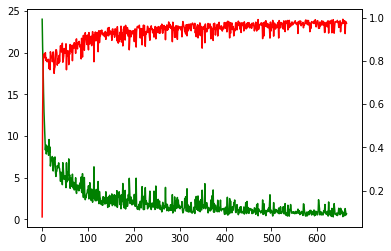

In [46]:
iters = [item["iter"] for item in result]
fig, ax1 = plt.subplots()
ax1.plot(iters,[item["loss"] for item in result],'g')
ax2 = ax1.twinx()
ax2.plot(iters,[item["accuracy"] for item in result],'r')
plt.show()

학습 그래프입니다.

In [47]:
torch.cuda.empty_cache()

In [48]:
print(f"gpu allocated : {torch.cuda.memory_allocated() // 1024**2} MB")
print(f"gpu reserved : {torch.cuda.memory_reserved() // 1024 ** 2}MB")

gpu allocated : 2739 MB
gpu reserved : 2910MB


gpu 메모리 사용량을 보는 코드

In [49]:
del batch_inputs
del batch_labels
del loss
del optimizer

한번 테스트 해보자

In [50]:
for data in datasetTrain[100:102]:
    print(tokenizer.convert_tokens_to_string(data["tokens"]))

김광현 을 둘러싼 주변 의 우려 는 너무 많이 던진다는 것 .
두산 은 주포 인 김동주 와 안경현 이 빠진 상황 이 라 타력 에 적 지 않 은 문제점 을 안 고 있 지만 29 일 잠실 롯데전 이 우천 으로 취소 되 는 바람 에 시간 을 벌 었 고 더구나 삼성 이 4 연패 로 2 위 로 추락 해 어부지리 로 1 위 로 올라서 는 행운 을 잡 았 다 .


In [51]:
inputs, labels = my_collate_fn(datasetTrain[100:102])
inputs = {k:v.to(device) for k,v in inputs.items()}
inputs

{'input_ids': tensor([[   101,   8935, 118649,  30842,   9633,   9105,  30873, 119091,   9689,
          118985,   9637,   9604,  26737,   9043,   9004,  32537,  47058,   9076,
           65096,  11018,   8870,    119,    102,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0],
         [   101,   9102,  21386,   9632,   9689,  55530,   9640,   8935,  18778,
           16323, 

In [52]:
model.eval()
with torch.no_grad():
    predict_label = model(**inputs)
    sp = model.softmax(predict_label)
    p = sp.argmax(dim=-1,keepdim=True).squeeze().cpu()

In [53]:
for data in p.numpy():
    print(tagIdConverter.convert_ids_to_tokens(data))

['O', 'B-PS', 'I-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-OG', 'I-OG', 'O', 'O', 'O', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DT', 'I-DT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OG', 'I-OG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [54]:
for data in labels.squeeze().numpy():
    print(tagIdConverter.convert_ids_to_tokens(data))

['O', 'B-PS', 'I-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['O', 'B-OG', 'I-OG', 'O', 'O', 'O', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

It work!

In [55]:
sp.cpu().view(-1,sp.size(-1)).argmax(dim=-1,keepdim=True).size()

torch.Size([194, 1])

In [56]:
correct = (sp.cpu().view(-1,sp.size(-1)).argmax(dim=-1) == labels.view(-1)).sum()
correct

tensor(120)

In [57]:
inputs["attention_mask"].view(-1).sum()

tensor(120, device='cuda:0')

In [58]:
accuracy = correct / inputs["attention_mask"].view(-1).sum()
accuracy

tensor(1., device='cuda:0')

accuracy는 다음과 같이 구해져요.

In [59]:
model.eval()
collect_list = []
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_i,batch_l in tepoch:
            batch_inputs = {k: v.cuda(device) for k, v in list(batch_i.items())}
            batch_labels = batch_l.cuda(device)
            output = model(**batch_inputs)
            loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))
            
            prediction = output.view(-1, output.size(-1)).argmax(dim=-1)
            correct = (prediction == batch_labels.view(-1)).sum().item()
            accuracy = correct / batch_inputs["attention_mask"].view(-1).sum()
            
            collect_list.append({"loss":loss.item(),"accuracy":accuracy, "batch_size":batch_labels.size(0),
                                "predict":output.argmax(dim=-1).cpu(),
                                "actual":batch_labels.cpu(),
                                "attention_mask":batch_inputs["attention_mask"].cpu()})

100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 74.40batch/s]


In [60]:
def getConfusionMatrix(predict,actual,attention_mask):
    ret = torch.zeros((22,22),dtype=torch.long)
    for i,(p_s,a_s) in enumerate(zip(predict,actual)):
        for j,(p,a) in enumerate(zip(p_s,a_s)):
            ret[p,a] += attention_mask[i,j]
    return ret

단순하게 confusion matrix를 계산하는 함수. 클래스 22개 정해져 있음.

In [61]:
getConfusionMatrix(torch.tensor([[0,1]]),torch.tensor([[1,1]]),torch.tensor([[1,1]]))

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 

In [62]:
total_loss = 0
total_accuracy = 0
total_size = 0
confusion = torch.zeros((22,22),dtype=torch.long)

for item in collect_list:
    batch_size = item["batch_size"]
    total_loss += batch_size * item["loss"]
    total_accuracy += batch_size * item["accuracy"]
    total_size += batch_size
    confusion += getConfusionMatrix(item["predict"],item["actual"],item["attention_mask"])
print(f"""average_loss : {total_loss/total_size}, average_accuracy : {total_accuracy/total_size}, size :{total_size}""")

average_loss : 0.16166621172241866, average_accuracy : 0.9605389833450317, size :500


test로 보면 결과가 나왔어요. 96% 나와요. F1 스코어는 아직입니다.

In [73]:
confusion = confusion[0:21][0:21]

Outside 토큰에 해당하는 곳을 짜르겠습니다.

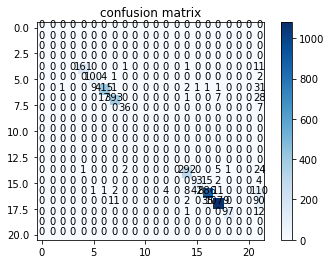

In [74]:
import itertools

plt.title("confusion matrix")
plt.imshow(confusion,cmap='Blues')

plt.colorbar()
for i,j in itertools.product(range(confusion.shape[0]),range(confusion.shape[1])):
    plt.text(j,i,"{:}".format(confusion[i,j]),horizontalalignment="center",color="black" if i == j else "black")
plt.show()

혼동행렬을 보면 별로인것 같습니다.
왼쪽이 predict이고 밑이 actual입니다.

$$Precision(class = a) = \frac{TP(class = a)}{TP(class = a)+FP(class = a)}$$

$$Recall(class = a) = \frac{TP(class = a)}{TP(class = a)+FN(class = a)}$$

$$F1Score(class = a) = \frac{2}{\frac{1}{Precision(class = a)}+\frac{1}{Recall(class = a)} }$$

F1Score는 다음과 같이 주어집니다.

다른 클래스에 대해서도 모두 해보자

In [75]:
def getF1Score(confusion,c):
    TP = confusion[c,c]
    FP = confusion[c].sum() - TP
    FN = confusion[:,c].sum() - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1Score = (2*precision*recall)/(precision + recall)
    return f1Score

In [77]:
for i in range(21):
    f1 = getF1Score(confusion,i)
    print(f"class {i} f1 score : {f1}")

class 0 f1 score : nan
class 1 f1 score : nan
class 2 f1 score : nan
class 3 f1 score : nan
class 4 f1 score : 0.9583332538604736
class 5 f1 score : 0.9216590523719788
class 6 f1 score : 0.9232480525970459
class 7 f1 score : 0.9203747510910034
class 8 f1 score : 0.8780487179756165
class 9 f1 score : nan
class 10 f1 score : nan
class 11 f1 score : nan
class 12 f1 score : nan
class 13 f1 score : nan
class 14 f1 score : 0.9240506887435913
class 15 f1 score : 0.7439999580383301
class 16 f1 score : 0.885114848613739
class 17 f1 score : 0.9293712377548218
class 18 f1 score : 0.932692289352417
class 19 f1 score : nan
class 20 f1 score : nan
